In [1]:
%pip install huggingface_hub wandb tiktoken datasets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 141.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 127.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 164.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 162.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from huggingface_hub import notebook_login
import wandb

wandb.login()
notebook_login()

wandb: Currently logged in as: kevinv3796. Use `wandb login --relogin` to force relogin


# Model Definition

In [2]:
#this cell doesn't have any changes from https://wingedsheep.com/building-a-language-model/
import torch
import numpy as np
import matplotlib.pyplot as plt

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


class TokenEmbedding(torch.nn.Module):
    """
    PyTorch module that converts tokens into embeddings.

    Input dimension is: (batch_size, sequence_length)
    Output dimension is: (batch_size, sequence_length, d_model)
    """

    def __init__(self, d_model, number_of_tokens):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(
            num_embeddings=number_of_tokens,
            embedding_dim=d_model
        )

    def forward(self, x):
        return self.embedding_layer(x)


class PositionalEncoding(torch.nn.Module):
    """
    Pytorch module that creates a positional encoding matrix. This matrix will later be added to the
    transformer's input embeddings to provide a sense of position of the sequence elements.
    """

    def __init__(self, d_model, max_sequence_length):
        super().__init__()
        self.d_model = d_model
        self.max_sequence_length = max_sequence_length
        self.positional_encoding = self.create_positional_encoding()

    def create_positional_encoding(self):
        """
        Creates a positional encoding matrix of size (max_sequence_length, d_model).
        """

        # Initialize positional encoding matrix
        positional_encoding = np.zeros((self.max_sequence_length, self.d_model))

        # Calculate positional encoding for each position and each dimension
        for pos in range(self.max_sequence_length):
            for i in range(0, self.d_model, 2):
                # Apply sin to even indices in the array; indices in Python start at 0 so i is even.
                positional_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / self.d_model)))

                if i + 1 < self.d_model:
                    # Apply cos to odd indices in the array; we add 1 to i because indices in Python start at 0.
                    positional_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * i) / self.d_model)))

        # Convert numpy array to PyTorch tensor and return it
        return torch.from_numpy(positional_encoding).float().to(get_device())

    def forward(self, x):
        """
        Adds the positional encoding to the input embeddings at the corresponding positions.
        """
        # Add positional encodings to input embeddings. The ":" indexing ensures we only add positional encodings up
        # to the length of the sequence in the batch. x.size(0) is the batch size, so this is a way to make sure
        # we're not adding extra positional encodings.
        positional_encoding = self.positional_encoding[:x.size(1), :]
        return x + positional_encoding


class MaskedSelfAttention(torch.nn.Module):
    """
    Pytorch module for a self attention layer.
    This layer is used in the MultiHeadedSelfAttention module.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, head_dimension)
    """

    def __init__(self, embedding_dimension, head_dimension):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = head_dimension
        self.query_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.key_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.value_layer = torch.nn.Linear(embedding_dimension, self.head_dimension)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x, mask):
        """
        Compute the self attention.

        x dimension is: (batch_size, sequence_length, embedding_dimension)
        output dimension is: (batch_size, sequence_length, head_dimension)
        mask dimension is: (batch_size, sequence_length)

        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """

        # x dimensions are: (batch_size, sequence_length, embedding_dimension)
        # query, key, value dimensions are: (batch_size, sequence_length, head_dimension)
        query = self.query_layer(x)
        key = self.key_layer(x)
        value = self.value_layer(x)

        # Calculate the attention weights.
        # attention_weights dimensions are: (batch_size, sequence_length, sequence_length)
        attention_weights = torch.matmul(query, key.transpose(-2, -1))

        # Scale the attention weights.
        attention_weights = attention_weights / np.sqrt(self.head_dimension)

        # Apply the mask to the attention weights, by setting the masked tokens to a very low value.
        # This will make the softmax output 0 for these values.
        mask = mask.reshape(attention_weights.shape[0], 1, attention_weights.shape[2])
        attention_weights = attention_weights.masked_fill(mask == 0, -1e9)

        # Softmax makes sure all scores are between 0 and 1 and the sum of scores is 1.
        # attention_scores dimensions are: (batch_size, sequence_length, sequence_length)
        attention_scores = self.softmax(attention_weights)

        # The attention scores are multiplied by the value
        # Values of tokens with high attention score get highlighted because they are multiplied by a larger number,
        # and tokens with low attention score get drowned out because they are multiplied by a smaller number.
        # Output dimensions are: (batch_size, sequence_length, head_dimension)
        return torch.bmm(attention_scores, value)


class MaskedMultiHeadedSelfAttention(torch.nn.Module):
    """
    Pytorch module for a multi head attention layer.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, embedding_dimension)
    """

    def __init__(self, embedding_dimension, number_of_heads):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = embedding_dimension // number_of_heads
        self.number_of_heads = number_of_heads

        # Create the self attention modules
        self.self_attentions = torch.nn.ModuleList(
            [MaskedSelfAttention(embedding_dimension, self.head_dimension) for _ in range(number_of_heads)])

        # Create a linear layer to combine the outputs of the self attention modules
        self.output_layer = torch.nn.Linear(number_of_heads * self.head_dimension, embedding_dimension)

    def forward(self, x, mask):
        """
        Compute the multi head attention.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        mask dimensions are: (batch_size, sequence_length)
        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """
        # Compute the self attention for each head
        # self_attention_outputs dimensions are:
        # (number_of_heads, batch_size, sequence_length, head_dimension)
        self_attention_outputs = [self_attention(x, mask) for self_attention in self.self_attentions]

        # Concatenate the self attention outputs
        # self_attention_outputs_concatenated dimensions are:
        # (batch_size, sequence_length, number_of_heads * head_dimension)
        concatenated_self_attention_outputs = torch.cat(self_attention_outputs, dim=2)

        # Apply the output layer to the concatenated self attention outputs
        # output dimensions are: (batch_size, sequence_length, embedding_dimension)
        return self.output_layer(concatenated_self_attention_outputs)


class FeedForward(torch.nn.Module):
    """
    Pytorch module for a feed forward layer.

    A feed forward layer is a fully connected layer with a ReLU activation function in between.
    """

    def __init__(self, embedding_dimension, feed_forward_dimension):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.feed_forward_dimension = feed_forward_dimension
        self.linear_1 = torch.nn.Linear(embedding_dimension, feed_forward_dimension)
        self.linear_2 = torch.nn.Linear(feed_forward_dimension, embedding_dimension)

    def forward(self, x):
        """
        Compute the feed forward layer.
        """
        return self.linear_2(torch.relu(self.linear_1(x)))


class DecoderLayer(torch.nn.Module):
    """
    Pytorch module for an encoder layer.

    An encoder layer consists of a multi-headed self attention layer, a feed forward layer and dropout.

    Input dimension is: (batch_size, sequence_length, embedding_dimension)
    Output dimension is: (batch_size, sequence_length, embedding_dimension)
    """

    def __init__(
            self,
            embedding_dimension,
            number_of_heads,
            feed_forward_dimension,
            dropout_rate
    ):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_heads = number_of_heads
        self.feed_forward_dimension = feed_forward_dimension
        self.dropout_rate = dropout_rate

        self.multi_headed_self_attention = MaskedMultiHeadedSelfAttention(embedding_dimension, number_of_heads)
        self.feed_forward = FeedForward(embedding_dimension, feed_forward_dimension)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.layer_normalization_1 = torch.nn.LayerNorm(embedding_dimension)
        self.layer_normalization_2 = torch.nn.LayerNorm(embedding_dimension)

    def forward(self, x, mask):
        """
        Compute the encoder layer.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        mask dimensions are: (batch_size, sequence_length)
        mask values are: 0 or 1. 0 means the token is masked, 1 means the token is not masked.
        """

        # Layer normalization 1
        normalized_x = self.layer_normalization_1(x)

        # Multi headed self attention
        attention_output = self.multi_headed_self_attention(normalized_x, mask)

        # Residual output
        residual_output = x + attention_output

        # Layer normalization 2
        normalized_residual_output = self.layer_normalization_2(residual_output)

        # Feed forward
        feed_forward_output = self.feed_forward(normalized_residual_output)

        # Dropout
        if self.training:
            feed_forward_output = self.dropout(feed_forward_output)

        # Residual output
        return residual_output + feed_forward_output


class DecoderStack(torch.nn.Module):
    """
    The decoder stack consists of multiple decoder layers in sequence.
    """

    def __init__(
            self,
            embedding_dimension,
            number_of_layers,
            number_of_heads,
            feed_forward_dimension,
            dropout_rate,
            max_sequence_length
    ):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_layers = number_of_layers
        self.number_of_heads = number_of_heads
        self.feed_forward_dimension = feed_forward_dimension
        self.dropout_rate = dropout_rate
        self.max_sequence_length = max_sequence_length

        # Create the encoder layers
        self.encoder_layers = torch.nn.ModuleList(
            [DecoderLayer(embedding_dimension, number_of_heads, feed_forward_dimension, dropout_rate) for _ in
             range(number_of_layers)])

    def forward(self, x, mask):
        decoder_outputs = x
        for decoder_layer in self.encoder_layers:
            decoder_outputs = decoder_layer(decoder_outputs, mask)

        return decoder_outputs


class LMHead(torch.nn.Module):
    """
    Pytorch module for the language model head.
    The language model head is a linear layer that maps the embedding dimension to the vocabulary size.
    """

    def __init__(self, embedding_dimension, number_of_tokens):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.number_of_tokens = number_of_tokens
        self.linear = torch.nn.Linear(embedding_dimension, number_of_tokens)

    def forward(self, x):
        """
        Compute the language model head.

        x dimensions are: (batch_size, sequence_length, embedding_dimension)
        output dimensions are: (batch_size, sequence_length, number_of_tokens)
        """
        # Compute the linear layer
        # linear_output dimensions are: (batch_size, sequence_length, number_of_tokens)
        linear_output = self.linear(x)

        return linear_output


class LanguageModel(torch.nn.Module):
    """
    Pytorch module for a language model.
    """

    def __init__(
            self,
            number_of_tokens,  # The number of tokens in the vocabulary
            max_sequence_length=512,  # The maximum sequence length to use for attention
            embedding_dimension=512,  # The dimension of the token embeddings
            number_of_layers=6,  # The number of decoder layers to use
            number_of_heads=4,  # The number of attention heads to use
            feed_forward_dimension=None,  # The dimension of the feed forward layer
            dropout_rate=0.1  # The dropout rate to use
    ):
        super().__init__()
        self.number_of_tokens = number_of_tokens
        self.max_sequence_length = max_sequence_length
        self.embedding_dimension = embedding_dimension
        self.number_of_layers = number_of_layers
        self.number_of_heads = number_of_heads

        if feed_forward_dimension is None:
            # GPT-2 paper uses 4 * embedding_dimension for the feed forward dimension
            self.feed_forward_dimension = embedding_dimension * 4
        else:
            self.feed_forward_dimension = feed_forward_dimension

        self.dropout_rate = dropout_rate

        # Create the token embedding layer
        self.token_embedding = TokenEmbedding(embedding_dimension, number_of_tokens)

        # Create the positional encoding layer
        self.positional_encoding = PositionalEncoding(embedding_dimension, max_sequence_length)

        # Create the normalization layer
        self.layer_normalization = torch.nn.LayerNorm(embedding_dimension)

        # Create the decoder stack
        self.decoder = DecoderStack(
            embedding_dimension=embedding_dimension,
            number_of_layers=number_of_layers,
            number_of_heads=number_of_heads,
            feed_forward_dimension=self.feed_forward_dimension,
            dropout_rate=dropout_rate,
            max_sequence_length=max_sequence_length
        )

        # Create the language model head
        self.lm_head = LMHead(embedding_dimension, number_of_tokens)

    def forward(self, x, mask):
        # Compute the token embeddings
        # token_embeddings dimensions are: (batch_size, sequence_length, embedding_dimension)
        token_embeddings = self.token_embedding(x)

        # Compute the positional encoding
        # positional_encoding dimensions are: (batch_size, sequence_length, embedding_dimension)
        positional_encoding = self.positional_encoding(token_embeddings)

        # Post embedding layer normalization
        positional_encoding_normalized = self.layer_normalization(positional_encoding)

        decoder_outputs = self.decoder(positional_encoding_normalized, mask)
        lm_head_outputs = self.lm_head(decoder_outputs)

        return lm_head_outputs

    def save_checkpoint(self, path):
        print(f'Saving checkpoint {path}')
        torch.save({
            'number_of_tokens': self.number_of_tokens,
            'max_sequence_length': self.max_sequence_length,
            'embedding_dimension': self.embedding_dimension,
            'number_of_layers': self.number_of_layers,
            'number_of_heads': self.number_of_heads,
            'feed_forward_dimension': self.feed_forward_dimension,
            'dropout_rate': self.dropout_rate,
            'model_state_dict': self.state_dict()
        }, path)

    @staticmethod
    def load_checkpoint(path) -> 'LanguageModel':
        checkpoint = torch.load(path)
        model = LanguageModel(
            number_of_tokens=checkpoint['number_of_tokens'],
            max_sequence_length=checkpoint['max_sequence_length'],
            embedding_dimension=checkpoint['embedding_dimension'],
            number_of_layers=checkpoint['number_of_layers'],
            number_of_heads=checkpoint['number_of_heads'],
            feed_forward_dimension=checkpoint['feed_forward_dimension'],
            dropout_rate=checkpoint['dropout_rate']
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        return model.to(get_device())


class AutoregressiveWrapper(torch.nn.Module):
    """
    Pytorch module that wraps a GPT model and makes it autoregressive.
    """

    def __init__(self, gpt_model):
        super().__init__()
        self.model = gpt_model
        self.max_sequence_length = self.model.max_sequence_length

    def forward(self, x, mask):
        """
        Autoregressive forward pass
        """
        #x.shape, mask.shape = (batch_size, sequence_length)
        inp, target = x[:, :-1], x[:, 1:]
        mask = mask[:, :-1]

        #inp.shape, mask.shape = (batch_size, sequence length - 1 (see above))
        output = self.model(inp, mask)
        return output, target

    def next_token_probabilities(self, x, mask, temperature=1.0):
        """
        Calculate the token probabilities for the next token in the sequence.
        """
        logits = self.model(x, mask)[:, -1]

        # Apply temperature
        if temperature != 1.0:
            logits = logits / temperature

        # Apply the softmax
        probabilities = torch.softmax(logits, dim=-1)

        return probabilities

    def save_checkpoint(self, path):
        self.model.save_checkpoint(path)

    @staticmethod
    def load_checkpoint(path) -> 'AutoregressiveWrapper':
        model = LanguageModel.load_checkpoint(path)
        return AutoregressiveWrapper(model).to(get_device())

# Tokenizer

In [3]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4")
eos_token_id = enc.eot_token
eos_token = enc.decode([eos_token_id])
eos_token

'<|endoftext|>'

# Dataset creation and Preprocessing

In [4]:
from datasets import load_dataset
from types import SimpleNamespace

config = SimpleNamespace(
    total_samples = 10000, #change this based on whether training or sweeping for hyperparams, to make standard epoch times shorter or longer
    valid_size = 0.2,
    batch_size = 14,
    max_length = 512,
    epochs=10,
    lr=0.0001,
    max_grad_norm = 0.5,
    embedding_dimension = 256,
    number_of_heads=4,
    number_of_layers=3,
    dropout_rate=0.1,
    eos_token_id = eos_token_id,
    eos_token = eos_token,
)


small_data = load_dataset("ArtifactAI/arxiv_python_research_code", split=f"train[:{config.total_samples}]")
train_data_pt = small_data.with_format("torch", device=get_device())
split_data = train_data_pt.train_test_split(test_size=config.valid_size)

Resolving data files:   0%|          | 0/26 [00:00<?, ?it/s]

In [5]:
code_snippets = split_data["train"]["code"]
val_code_snippets = split_data["test"]["code"]

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class CodeSnippetDataset(Dataset):
    def __init__(self, snippets, tokenizer):
        self.snippets = snippets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.snippets)

    def __getitem__(self, idx):
        snippet = self.snippets[idx]

        # Tokenize the snippet
        input_ids = self.tokenizer.encode(snippet, allowed_special = "all")
        attention_mask = [1] * len(input_ids)  # Assume all tokens are attended to

        return input_ids, attention_mask

def collate_fn(batch, max_length):
    input_ids_list, attention_mask_list = [], []

    # Process each snippet in the batch
    for input_ids, attention_mask in batch:
        # Truncate input_ids and attention_mask based on the maximum sequence length in the batch
        input_ids = input_ids[:max_length]
        attention_mask = attention_mask[:max_length]

        # Pad input_ids and attention_mask to max_length
        padding_length = max_length - len(input_ids)
        padded_input_ids = input_ids + [eos_token_id] * padding_length
        padded_attention_mask = attention_mask + [0] * padding_length

        input_ids_list.append(padded_input_ids)
        attention_mask_list.append(padded_attention_mask)

    # Convert lists to tensors
    input_ids_tensor = torch.tensor(input_ids_list, dtype=torch.long)
    attention_mask_tensor = torch.tensor(attention_mask_list, dtype=torch.long)

    return input_ids_tensor, attention_mask_tensor


# Create the dataset
train_dataset = CodeSnippetDataset(code_snippets, enc)
val_dataset = CodeSnippetDataset(val_code_snippets, enc)

# Create a DataLoader with collate_fn to handle padding
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=lambda b: collate_fn(b, config.max_length + 1))
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=lambda b: collate_fn(b, config.max_length + 1))

# Training Loop Definition

In [7]:
from tqdm import tqdm
class Trainer:
    def __init__(self, model, tokenizer, optimizer=None, scheduler = None):
        super().__init__()
        self.model = model
        if optimizer is None:
            self.optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        else:
            self.optimizer = optimizer

        if scheduler:
            self.scheduler = scheduler
        self.tokenizer = tokenizer
        self.loss_function = torch.nn.CrossEntropyLoss()

    def train(self, dataloader, epochs, config):
        for epoch in range(epochs):
            self.model.train()

            for batch_idx, batch in enumerate(tqdm(dataloader)):
                input_ids, attention_mask = batch

                # Create the input and mask tensors
                input_ids, attention_mask = input_ids.to(get_device()), attention_mask.to(get_device())

                # Forward pass
                #input_ids and attention_mask dimensions are (batch_size, sequence_length) (8,512)
                outputs, targets = self.model(x=input_ids, mask=attention_mask)

                # Reshape targets to match the format expected by CrossEntropyLoss
                targets_flat = targets.reshape(-1)  # Flatten to shape [batch_size * sequence_length]

                # Flatten logits to shape [batch_size * sequence_length, num_classes]
                outputs_flat = outputs.reshape(-1, outputs.shape[2])

                # Compute loss
                loss = self.loss_function(outputs_flat, targets_flat)

                # Backpropagate the loss.
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Clip the gradients. This is used to prevent exploding gradients.
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), config.max_grad_norm)

                # Log batch-level loss
                wandb.log({'train/loss': loss.item(), 'batch': batch_idx + 1})

            # Evaluate the model on validation data
            val_loss = self.evaluate(val_dataloader)
            if self.scheduler:
                self.scheduler.step(val_loss)
            wandb.log({'val/loss': val_loss, 'epoch': epoch + 1})
            print('val/loss', val_loss, 'epoch', epoch + 1)

    def evaluate(self, dataloader):
        self.model.eval()
        val_loss = 0.0
        num_batches = len(dataloader)

        with torch.no_grad():
            for batch in dataloader:
                input_ids, attention_mask = batch
                input_ids, attention_mask = input_ids.to(get_device()), attention_mask.to(get_device())

                # Forward pass
                outputs, targets = self.model(x=input_ids, mask=attention_mask)
                targets_flat = targets.reshape(-1)
                outputs_flat = outputs.reshape(-1, outputs.shape[2])

                # Compute loss
                loss = self.loss_function(outputs_flat, targets_flat)
                val_loss += loss.item()

        # Calculate average validation loss
        val_loss /= num_batches
        return val_loss

# Training Run 1: Naive (No optimization)

100%|██████████| 1000/1000 [01:37<00:00, 10.25it/s]


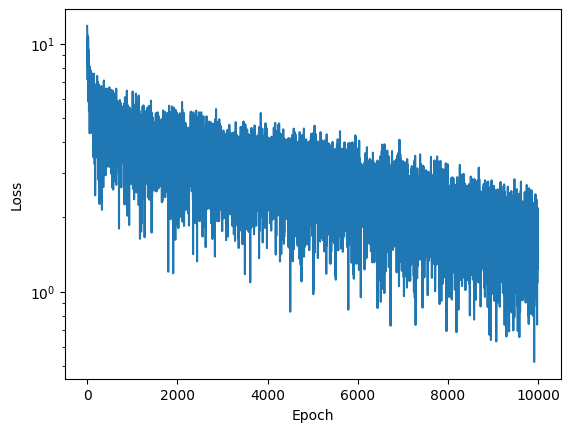

batch,▂▃▅▆▁▃▅▇▁▃▅▇▁▃▅▇▂▃▅▇▂▄▅▇▂▄▆▇▂▄▆█▂▄▆█▂▄▆█
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train/batch_loss,█▇▅▆▄▅▆▅▄▄▅▄▄▄▃▄▄▃▄▃▃▄▁▄▂▂▂▄▂▁▂▃▂▁▂▃▁▂▂▂
val/loss,█▆▆▅▄▄▃▂▂▁
batch,1000
epoch,10
train/batch_loss,1.31058
val/loss,1.99151


Saving checkpoint ./trained_model


In [8]:
wandb.init(project = "transformer_from_scratch", job_type = "train", config = config, tags = ["training","trial_run"])
# Create the tokenizer
tokenizer = enc
number_of_tokens = tokenizer.n_vocab

# Create the model
model = AutoregressiveWrapper(LanguageModel(
    embedding_dimension=config.embedding_dimension,
    number_of_tokens=number_of_tokens,
    number_of_heads=config.number_of_heads,
    number_of_layers=config.number_of_layers,
    dropout_rate=config.dropout_rate,
    max_sequence_length=config.max_length
)).to(get_device())

# Train the model
trainer = Trainer(model, tokenizer)
loss_per_epoch = trainer.train(train_dataloader, epochs=config.epochs)

# Plot the loss per epoch in log scale
plt.plot(loss_per_epoch)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

wandb.run.finish()
model.save_checkpoint('./trained_model')

In [9]:
model_size = sum(t.numel() for t in model.parameters())
print(f"Model size: {model_size/1000**2:.1f}M parameters")

Model size: 53.8M parameters


We trained the above model with arbitrary hyperparams to see if it learns anything from the data.
The model has 53.8M parameters. The training tool ~20 minutes. 
The training loss did go down as such:
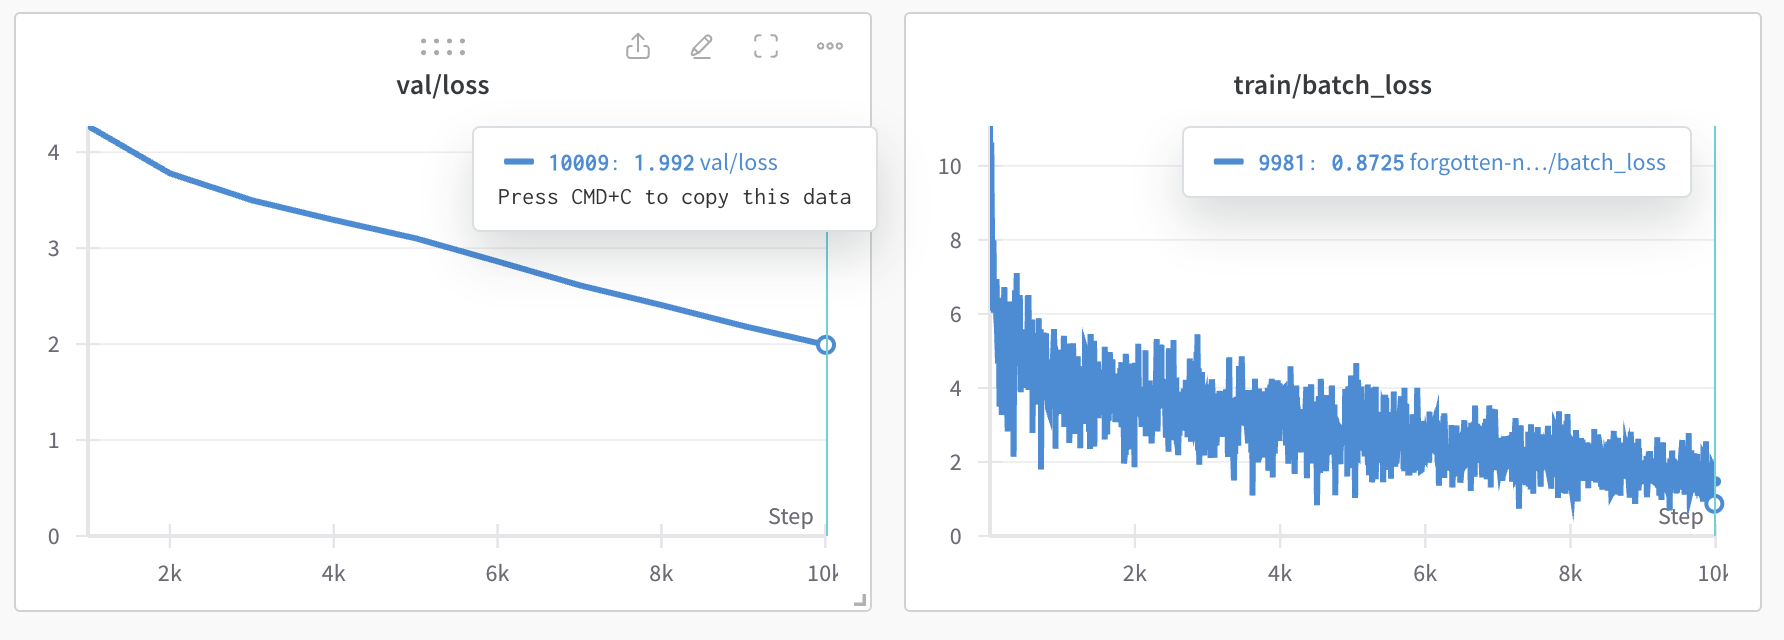

The training is quite noisy - we need LR scheduling and other hyperparam optimization to get the best training.
The validation loss is also far from plateaud, so we need to train for many more epochs to get the best out of our current data. (8000 code snippets)


# Generation using Naive model

In [10]:
#already ran this one for this run
def pad_left(sequence, final_length, padding_token):
    return [padding_token] * (final_length - len(sequence)) + sequence

class Generator:
    def __init__(
            self,
            model,
            tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def generate(
            self,
            max_tokens_to_generate: int,
            prompt: str = None,
            temperature: float = 1.0,
            eos_token: int = None,
            padding_token: int = config.eos_token_id):

        self.model.eval()

        if prompt is None:
            start_tokens = [config.eos_token_id]
        else:
            start_tokens = self.tokenizer.encode(prompt, allowed_special = "all")

        input_tensor = torch.tensor(
            pad_left(
                sequence=start_tokens,
                final_length=self.model.max_sequence_length + 1,
                padding_token=padding_token
            ),
            dtype=torch.long
        ).to(get_device())

        num_dims = len(input_tensor.shape)

        if num_dims == 1:
            input_tensor = input_tensor[None, :]

        out = input_tensor
        for _ in range(max_tokens_to_generate):

            x = out[:, -self.model.max_sequence_length:]

            mask = torch.ones_like(x)
            mask[x == padding_token] = 0

            # Compute the next token probabilities
            next_token_probabilities = self.model.next_token_probabilities(
                x=x,
                temperature=temperature,
                mask=mask
            )

            # Sample the next token from the probability distribution
            next_token = torch.multinomial(next_token_probabilities, num_samples=1)

            # Append the next token to the output
            out = torch.cat([out, next_token], dim=1)

            # If the end of sequence token is reached, stop generating tokens
            if eos_token is not None and next_token == eos_token:
                break

        generated_tokens = out[0].tolist()
        return self.tokenizer.decode(generated_tokens)
        #return ''.join([self.tokenizer.decode(token) for token in generated_tokens])


In [11]:
# Generate text
max_tokens_to_generate = 512
generator = Generator(model, tokenizer)
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
"""
generated_text = generator.generate(
    max_tokens_to_generate=max_tokens_to_generate,
    prompt=txt,
    padding_token=eos_token_id
)
print(generated_text.replace(eos_token, ''))

# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
Wedb_grid z
zad_max_ksampleAIN//+14 = ux_all(np Attention.fromarray cost_priorarna
sh75.shape, u//b)/box, SFR, Numpy_xy P
test, Obj, rep(Y,)
  *(b,(vecain](S_detfile, NBH, schedulegS z OUT[:, -ifhcurS_ABS'.flattenSphi.03
Z6
fc
surface -.compile
x07, -reshape
search
   while -b00 -bw - checked -S   -m, L140].
|x.K.e zS -S   -�.ip   -NS  gft -tNrulsNS   -264deriv - S ph_H43   zY   -╔(-xs96   -hz - heavily -styleparams -PX -v -�   -55 -cluster -:- - longitudere119
styleS   - Lou!-- -██URE.p   -fc   -td *=   -   {{.constants -Lo remote z AND BRals -pprowidth -55   -S   -\SCRIPT -NUM     character}},ableslo78 -M   -CityS   z   z -     Sa     -39 -   -uls   correlation mass -:\(profile calcul Telescopeparams -inalg - -all Debian templates_y   -751   - S   -m,   -   -79S   z Rrr - MK --port)+   -   -32     -   - Puls -S   z	d - struct -175 masses   -mass   -   -343， then  SELECT136 -pp  601  

As we can see, the model is far from ideal still.

# Wandb Sweep for Hyperparams

In [8]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
default_config = SimpleNamespace(
    total_samples = 500, #can't afford to sweep with a lot of samples since the training times are too long to run many experiments
    valid_size = 0.2,
    batch_size = 8,
    max_length = 512,
    epochs=3, #same as above
    lr=0.0001,
    weight_decay = 0.001,
    max_grad_norm = 0.5,
    embedding_dimension = 512,
    number_of_heads=8,
    number_of_layers=24,
    dropout_rate=0.1,
    eos_token_id = eos_token_id,
    eos_token = eos_token,
)

# Create the tokenizer
tokenizer = enc
number_of_tokens = tokenizer.n_vocab

# Create the model
model = AutoregressiveWrapper(LanguageModel(
    embedding_dimension=default_config.embedding_dimension,
    number_of_tokens=number_of_tokens,
    number_of_heads=default_config.number_of_heads,
    number_of_layers=default_config.number_of_layers,
    dropout_rate=default_config.dropout_rate,
    max_sequence_length=config.max_length
)).to(get_device())

def agent_train(config = default_config):
  with wandb.init(config=config):
        optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay = config.weight_decay)
        scheduler = ReduceLROnPlateau(optimizer, 'min')
    
        # Train the model
        trainer = Trainer(model, tokenizer, optimizer, scheduler)
        loss_per_epoch = trainer.train(train_dataloader, epochs=default_config.epochs, config = config)

In [9]:
model_size = sum(t.numel() for t in model.parameters())
print(f"Model size: {model_size/1000**2:.1f}M parameters")

Model size: 178.4M parameters


In [9]:
# method
sweep_config = {
    'method': 'random'
}

# hyperparameters
parameters_dict = {
    'max_grad_norm': {
        'values': [0.001, 0.01, 0.1]
    },
    'lr': {
        'distribution': 'log_uniform_values',
        'min': 1e-5,
        'max': 2e-3
    },
    'weight_decay': {
        'values': [0.001, 0.01, 0.1]
    },
}

In [10]:
sweep_config['parameters'] = parameters_dict
sweep_id = wandb.sweep(sweep_config, project="transformer_from_scratch")
wandb.agent(sweep_id, agent_train, count=10)

Create sweep with ID: qb4nlh6u
Sweep URL: https://wandb.ai/kevinv3796/transformer_from_scratch/sweeps/qb4nlh6u


wandb: Agent Starting Run: j3tfpnlf with config:
wandb: 	lr: 0.00025925411881842065
wandb: 	max_grad_norm: 0.1
wandb: 	weight_decay: 0.01


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/batch_loss,█▇▃▅▄▄▃▃▃▃▃▃▃▂▃▃▂▃▁▂▃▂▃▃▂▃▃▂▃▃▂▂▁▁▂▂▂▂▃▂
val/loss,█▄▁
batch,50
epoch,3
train/batch_loss,4.5788
val/loss,4.58237


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8hyaf6jb with config:
wandb: 	lr: 8.207946454122816e-05
wandb: 	max_grad_norm: 0.001
wandb: 	weight_decay: 0.01


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/batch_loss,▆█▄▅▄█▅▅▅▃▆▂▅▅▄▆▂▄▃▄▅▄▅▃▂▄▄▃▄▄▄▃▄▃▆▄▄▃▁▃
val/loss,█▄▁
batch,50
epoch,3
train/batch_loss,3.03475
val/loss,4.13835


wandb: Agent Starting Run: e7lvy3vj with config:
wandb: 	lr: 6.797599028235023e-05
wandb: 	max_grad_norm: 0.001
wandb: 	weight_decay: 0.01


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/batch_loss,▆███▃▆▄▃▅▆▃▅▂▄▄▄▁▅▄▅▅▂▃▄▇▇▃▃▅▄▅▄▂▂▄▁▄▃▁▄
val/loss,█▄▁
batch,50
epoch,3
train/batch_loss,2.72982
val/loss,3.96733


wandb: Agent Starting Run: dx1b6g7i with config:
wandb: 	lr: 0.0001982032496697067
wandb: 	max_grad_norm: 0.001
wandb: 	weight_decay: 0.01


100%|██████████| 50/50 [00:23<00:00,  2.15it/s]


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/batch_loss,▇▄█▅▄▅▅▅▇▆▃▅▃▃▄▃▃▃▂▅▅▄▃▁▂▄▆▂▂▁▁▃▂▃▄▁▂▆▃▃
val/loss,▅▁█
batch,50
epoch,3
train/batch_loss,2.22015
val/loss,3.90115


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j5uppz83 with config:
wandb: 	lr: 2.3951925591779825e-05
wandb: 	max_grad_norm: 0.001
wandb: 	weight_decay: 0.001


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/batch_loss,▅█▆▃▄▄▆▃▆▅▄█▄▇▂▅▃▄▇▄▂▅▁▃▅▄▄▁▁▃▄▄▃▄▄▄▂▅▅▃
val/loss,▁▂█
batch,50
epoch,3
train/batch_loss,1.59182
val/loss,3.94079


wandb: Agent Starting Run: v4kyx8nr with config:
wandb: 	lr: 0.0001358846450892872
wandb: 	max_grad_norm: 0.01
wandb: 	weight_decay: 0.01


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/batch_loss,█▇▄▄▄▆▂▆▅▁▁▄▅▆▃▃▄▃▄▃▂▂▃▄▆▃▅▂▃▂▄▃▂▄▂▁▃▄▃▄
val/loss,▁▃█
batch,50
epoch,3
train/batch_loss,1.70608
val/loss,4.04012


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: skm7720o with config:
wandb: 	lr: 2.555263647025529e-05
wandb: 	max_grad_norm: 0.001
wandb: 	weight_decay: 0.1


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/batch_loss,█▅▃▄▅▆▅▄▅▄▁▄▄▅▄▃▃▄▄▅▄▃▃▅▄▄▃▅▃▄▂▃▃▂▃▃▂▅▄▄
val/loss,▁▇█
batch,50
epoch,3
train/batch_loss,1.42454
val/loss,4.11201


wandb: Agent Starting Run: 76k04xcn with config:
wandb: 	lr: 0.0004159904256248784
wandb: 	max_grad_norm: 0.1
wandb: 	weight_decay: 0.01


100%|██████████| 50/50 [00:22<00:00,  2.18it/s]


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/batch_loss,█▆▅▆▆▄▁▇▆▂▄▃▅▃▄▄▄▃▄▃▂▅▄▄▂▄▄▃▂▄▄▄▁▄▂▆▄▅▁▃
val/loss,▁▄█
batch,50
epoch,3
train/batch_loss,0.93608
val/loss,4.25401


wandb: Agent Starting Run: 9k6gc1ks with config:
wandb: 	lr: 1.408587142228599e-05
wandb: 	max_grad_norm: 0.01
wandb: 	weight_decay: 0.1


100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/batch_loss,█▆▅▂▅▂▄▄▄▃▃▅▅▄▃▂▃▃▃▂▁▃▂▃▃▂▄▁▃▃▁▂▃▃▃▂▂▄▂▂
val/loss,▁▆█
batch,50
epoch,3
train/batch_loss,0.72543
val/loss,4.35879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8l7yu0hu with config:
wandb: 	lr: 2.785638307480532e-05
wandb: 	max_grad_norm: 0.1
wandb: 	weight_decay: 0.001


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


batch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/batch_loss,█▆▄▄▅▃▅▂▁▄▄▃▅▅▂▃▂▄▂▃▂▃▃▅▃▄▂▂▂▂▁▂▁▁▁▃▄▃▂▄
val/loss,▁▅█
batch,50
epoch,3
train/batch_loss,0.80884
val/loss,4.51452


From the above sweep:
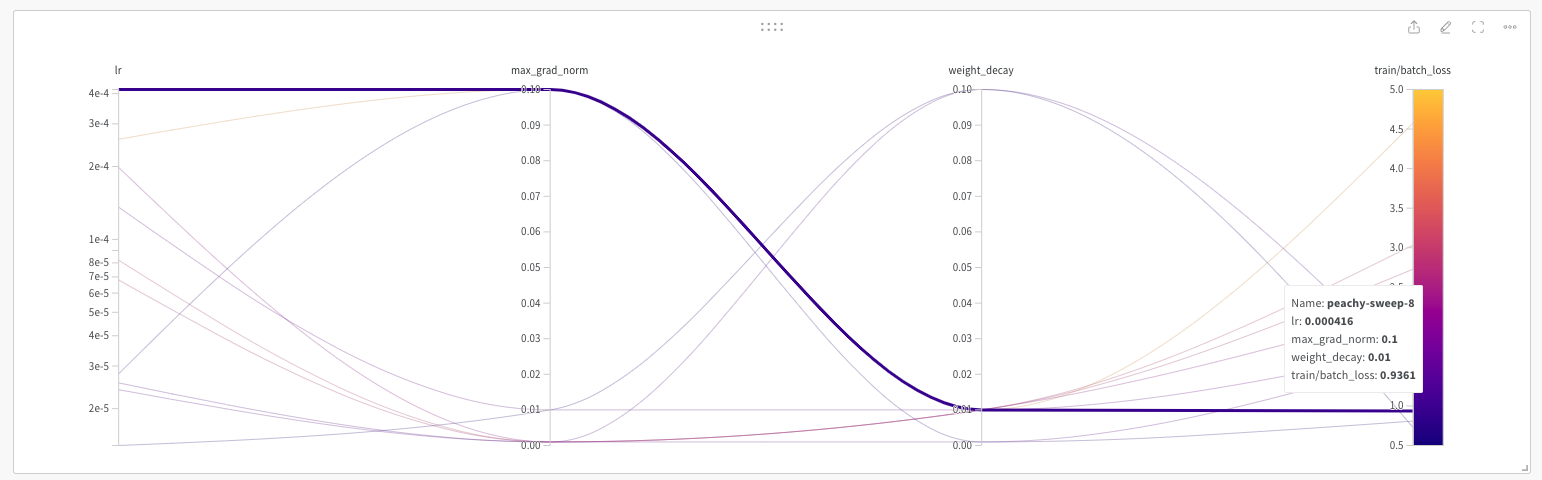
- LR = 4e-3
- max_grad_norm = 0.1
- weight_decay = 0.01

# Final Training

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

final_config = SimpleNamespace(
    total_samples = 10000, 
    valid_size = 0.2,
    batch_size = 14,
    max_length = 512,
    epochs=20, #doing twice as many epochs as our naive run, but the model's dimensions are bigger so this will take longer
    lr=4e-3,
    weight_decay = 0.01,
    max_grad_norm = 0.1,
    embedding_dimension = 512,
    number_of_heads=8,
    number_of_layers=24,
    dropout_rate=0.1,
    eos_token_id = eos_token_id,
    eos_token = eos_token,
)

# Create the tokenizer
tokenizer = enc
number_of_tokens = tokenizer.n_vocab

# Create the model
model = AutoregressiveWrapper(LanguageModel(
    embedding_dimension=final_config.embedding_dimension,
    number_of_tokens=number_of_tokens,
    number_of_heads=final_config.number_of_heads,
    number_of_layers=final_config.number_of_layers,
    dropout_rate=final_config.dropout_rate,
    max_sequence_length=final_config.max_length
)).to(get_device())


with wandb.init(project = "transformer_from_scratch", job_type = "train", config=final_config):
    optimizer = torch.optim.AdamW(model.parameters(), lr=final_config.lr, weight_decay = final_config.weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # Train the model
    trainer = Trainer(model, tokenizer, optimizer, scheduler)
    loss_per_epoch = trainer.train(train_dataloader, epochs=final_config.epochs, config = final_config)

    model.save_checkpoint('./trained_model')